In [207]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from scipy.special import jv, kv


In [209]:
# load unpolarized dipole data
input_file = '/Users/brandonmanley/Desktop/PhD/rcbkdipole/build/bin/dipole_data/unpolarized_dipole_xmin0.010000_xmax0.000001.dat'
dipole_df = pd.read_csv(input_file, sep=r'\s+', header=None, names=['xBj', 'ln(r)', 'N[ln(r)]'])


In [211]:
# compute N^{(c,d)}_{(a,b)}

Lam = 1 # GeV

# define the double-Bessel-dipole (DBD) transform
def N_DBD(pT, Q, z, xBj, inds):
    ia, ib, ic, id = inds
    prefactor = ((pT/Lam)**ic)*(((Q*np.sqrt(z*(1-z)))/Lam)**id)

    # select N(r, x = xBj)
    dipole = dipole_df[np.isclose(dipole_df['xBj'], xBj, atol=1e-7)]

    # riemann sum for integral
    sum = 0
    d = 0.01
    for _, irow in dipole.iterrows():
        u = irow['ln(r)']
        sum += d*(np.exp(u*(2+ic+id)))*jv(ia, (pT/Lam)*np.exp(u))*kv(ib, (Q/Lam)*np.sqrt(z*(1-z))*np.exp(u))*irow['N[ln(r)]']
        # sum += d*(np.exp(u*(2+ic+id)))*jv(ia, (pT/Lam)*np.exp(u))*kv(ib, (Q/Lam)*np.sqrt(z*(1-z))*np.exp(u))

    return prefactor*sum


# calculate the sum for various pT 
Q = np.sqrt(10) # GeV 
z = 0.2
pT_values = np.linspace(1, 10, 100)

N_pTs = [[] for i in range(4)]
for ipT in pT_values: 
    N_pTs[0].append(N_DBD(ipT, Q, z, 0.01, [0,0,0,0]))
    N_pTs[1].append(N_DBD(ipT, Q, z, 0.01, [1,0,0,0]))
    N_pTs[2].append(N_DBD(ipT, Q, z, 0.01, [0,1,0,0]))
    N_pTs[3].append(N_DBD(ipT, Q, z, 0.01, [1,1,0,0]))
    

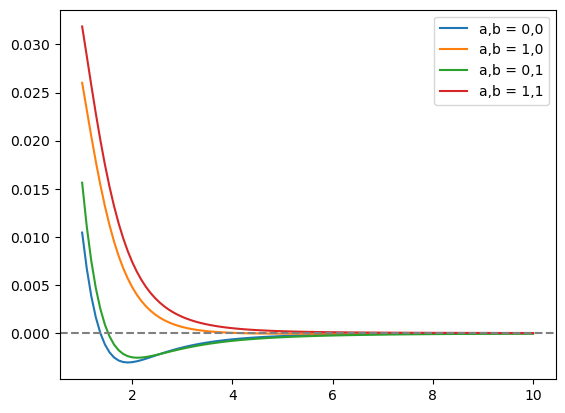

In [212]:
plt.plot(pT_values, N_pTs[0], label = "a,b = 0,0")
plt.plot(pT_values, N_pTs[1], label = "a,b = 1,0")
plt.plot(pT_values, N_pTs[2], label = "a,b = 0,1")
plt.plot(pT_values, N_pTs[3], label = "a,b = 1,1")
plt.legend()
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
plt.show()

In [11]:
for ir, r in enumerate(dipole_df['ln(r)'].values):
    delta = dipole_df['ln(r)'].values[ir+1] - r
    print(delta, r/delta, r)

0.009999999999999787 -1380.5560230000294 -13.80556023
0.009999999999999787 -1379.5560230000294 -13.79556023
0.009999999999999787 -1378.5560230000294 -13.78556023
0.009999999999999787 -1377.5560230000294 -13.77556023
0.009999999999999787 -1376.5560230000294 -13.76556023
0.009999999999999787 -1375.5560230000294 -13.75556023
0.009999999999999787 -1374.5560230000294 -13.74556023
0.010000000000001563 -1373.5560229997855 -13.73556023
0.009999999999999787 -1372.5560230000292 -13.72556023
0.009999999999999787 -1371.5560230000292 -13.71556023
0.009999999999999787 -1370.5560230000292 -13.70556023
0.009999999999999787 -1369.5560230000292 -13.69556023
0.009999999999999787 -1368.5560230000292 -13.68556023
0.009999999999999787 -1367.5560230000292 -13.67556023
0.009999999999999787 -1366.5560230000292 -13.66556023
0.010000000000001563 -1365.5560229997866 -13.65556023
0.009999999999999787 -1364.556023000029 -13.64556023
0.009999999999999787 -1363.556023000029 -13.63556023
0.009999999999999787 -1362.556

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [215]:
# load polarized data

indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d01_ones/'
input_files = [indir+'d01_NcNf3_ones_'+ia+'.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
data_files = [np.loadtxt(ifile) for ifile in input_files]

def to_array(data_files):
    dipoles = []
    for is10, s10_row in enumerate(data_files[0]):
        for ieta, eta in enumerate(s10_row):
            dipole_values = [ifile[is10, ieta] for ifile in data_files]
            dipoles.append([(is10+1)*0.01, (ieta+1)*0.01] + dipole_values)
    return dipoles

dipole_array = to_array(data_files)
pdipole_dfs = pd.DataFrame(dipole_array, columns = ['s10', 'eta', 'Q', 'G2', 'I3', 'I4', 'I5'])


In [279]:
# compute DBD transform

def PD_DBD(pT, Q, z, xBj, inds, amp_data):
    bas = np.sqrt((0.25*3.0)/(2*np.pi))
    ia, ib, ic, id = inds
    prefactor = ((pT/Lam)**ic)*(((Q*np.sqrt(z*(1-z)))/Lam)**id)*(1/(2*bas))
    d = 0.01

    eta_index = round((bas/d)*np.log((Q**2)/(xBj*(Lam**2))))
    sdipole = amp_data[:, eta_index]

    sum = 0
    for is10, amp in enumerate(sdipole):
        s10 = is10*d
        u = s10*(1/(2*bas))
        sum += d*np.exp(-u*(2+ic+id))*jv(ia, (pT/Lam)*np.exp(-u))*kv(ib, (Q/Lam)*np.sqrt(z*(1-z))*np.exp(-u))*amp
                        
    return prefactor*sum


# calculate the sum for various pT
Q = np.sqrt(5) # GeV 
z = 0.2
# pT_values = np.linspace(1, 10, 100)

Q_pTs = [[] for i in range(4)]
for ipT in pT_values: 
    
    Q_pTs[0].append(PD_DBD(ipT, Q, z, 0.01, [0,0,0,0], data_files[0]))
    Q_pTs[1].append(PD_DBD(ipT, Q, z, 0.01, [1,0,0,0], data_files[0]))
    # Q_pTs[2].append(PD_DBD(ipT, Q, z, 0.01, [0,1,0,0], 'Q'))
    # Q_pTs[3].append(PD_DBD(ipT, Q, z, 0.01, [1,1,0,0], 'Q'))



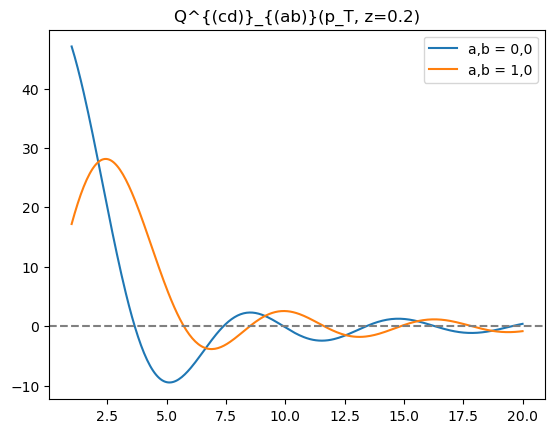

In [281]:
plt.plot(pT_values, Q_pTs[0], label = "a,b = 0,0")
plt.plot(pT_values, Q_pTs[1], label = "a,b = 1,0")
# plt.plot(pT_values, Q_pTs[2], label = "a,b = 0,1")
# plt.plot(pT_values, Q_pTs[3], label = "a,b = 1,1")
plt.legend()
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
plt.title('Q^{(cd)}_{(ab)}(p_T, z=0.2)')
plt.show()

In [333]:
# define functions needed for DSA
def A_TT(pT, Q, z, xBj):
    Q_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[0])
    G2_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[1])
    N_11 = N_DBD(pT, Q, z, xBj, [1,1,0,0])

    return N_11*(((1- 2*z)**2)*Q_11 + 2*((z**2) + ((1-z)**2))*G2_11)

def B_TT(pT, Q, z, xBj):
    Q_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[0])
    Q_21_10 = PD_DBD(pT, Q, z, xBj, [2,1,1,0], data_files[0])
    G2_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[1])
    G2_21_10 = PD_DBD(pT, Q, z, xBj, [2,1,1,0], data_files[1])
    I3_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[2])
    I3_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[2])
    I4_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[3])
    I4_21_10 = PD_DBD(pT, Q, z, xBj, [2,1,1,0], data_files[3])
    I4_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[3])
    I5_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[4])
    I5_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[4])
    I5_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[4])

    N_11 = N_DBD(pT, Q, z, xBj, [1,1,0,0])
    N_01_10 = N_DBD(pT, Q, z, xBj, [0,1,1,0])

    b_TT = 0.5*((1-2*z)**2)*N_01_10*Q_11
    b_TT += (z**2 + (1-z)**2)*N_01_10*G2_11 + N_11*(0.5*Q_11 + I3_11 - I3_01_10)
    b_TT += (z**2 + (1-z)**2)*N_11*(Q_21_10 + 2*G2_21_10 + I4_21_10 + I4_10_01 - I5_11 + I5_10_01 + I5_01_10)

    return (1-(2*z))*b_TT


def A_LT(pT, Q, z, xBj):
    Q_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[0])
    Q_00 = PD_DBD(pT, Q, z, xBj, [0,0,0,0], data_files[0])
    G2_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[1])

    N_11 = N_DBD(pT, Q, z, xBj, [1,1,0,0])
    N_00 = N_DBD(pT, Q, z, xBj, [0,0,0,0])

    return (1- 2*z)*(N_00*(2*G2_11 - Q_11) - N_11*Q_00)

    
def B_LT(pT, Q, z, xBj):
    
    Q_00 = PD_DBD(pT, Q, z, xBj, [0,0,0,0], data_files[0])
    Q_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[0])
    Q_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[0])
    Q_10_10 = PD_DBD(pT, Q, z, xBj, [1,0,1,0], data_files[0])
    
    G2_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[1])
    G2_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[1])
    
    I3_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[2])
    I3_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[2])
    I3_10_10 = PD_DBD(pT, Q, z, xBj, [1,0,1,0], data_files[2])
    
    I4_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[3])
    I4_21_10 = PD_DBD(pT, Q, z, xBj, [2,1,1,0], data_files[3])
    I4_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[3])
    
    I5_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[4])
    I5_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[4])
    I5_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[4])

    N_00 = N_DBD(pT, Q, z, xBj, [0,0,0,0])
    N_11 = N_DBD(pT, Q, z, xBj, [1,1,0,0])
    N_10_10 = N_DBD(pT, Q, z, xBj, [1,0,1,0])
    N_01_10 = N_DBD(pT, Q, z, xBj, [0,1,1,0])

    b_LT = N_00*(I3_11 - I3_01_10)
    b_LT += N_11*I3_10_10 
    b_LT += (z**2 + (1-z)**2)*N_00*(Q_01_10 - Q_11)
    b_LT -= (z**2 + (1-z)**2)*N_11*Q_10_10 
    b_LT -= 0.5*((1- 2*z)**2)*N_10_10*Q_11
    b_LT -= 0.5*((1- 2*z)**2)*(N_11 - N_01_10)*Q_00
    b_LT += ((1- 2*z)**2)*N_00*(3*G2_11 - 2*G2_01_10 + I4_21_10 + I4_10_01 - I5_11 + I5_01_10 + I5_10_01)
    b_LT += ((1- 2*z)**2)*N_10_10*G2_11
    
    return b_LT


def C_LT(pT, Q, z, xBj):
    
    Q_00 = PD_DBD(pT, Q, z, xBj, [0,0,0,0], data_files[0])
    Q_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[0])
    
    G2_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[1])
    G2_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[1])
    G2_10_10 = PD_DBD(pT, Q, z, xBj, [1,0,1,0], data_files[1])
    
    I3_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[2])
    
    I4_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[3])
    I4_21_10 = PD_DBD(pT, Q, z, xBj, [2,1,1,0], data_files[3])
    I4_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[3])
    I4_10_10 = PD_DBD(pT, Q, z, xBj, [1,0,1,0], data_files[3])
    I4_01_10 = PD_DBD(pT, Q, z, xBj, [0,1,1,0], data_files[3])
    I4_11_20 = PD_DBD(pT, Q, z, xBj, [1,1,2,0], data_files[3])
    I4_00_11 = PD_DBD(pT, Q, z, xBj, [0,0,1,1], data_files[3])
    I4_11_11 = PD_DBD(pT, Q, z, xBj, [1,1,1,1], data_files[3])
    I4_00_20 = PD_DBD(pT, Q, z, xBj, [0,0,2,0], data_files[3])
    
    I5_11 = PD_DBD(pT, Q, z, xBj, [1,1,0,0], data_files[4])
    I5_11_20 = PD_DBD(pT, Q, z, xBj, [1,1,2,0], data_files[4])
    I5_10_01 = PD_DBD(pT, Q, z, xBj, [1,0,0,1], data_files[4])
    I5_00_11 = PD_DBD(pT, Q, z, xBj, [0,0,1,1], data_files[4])

    N_00 = N_DBD(pT, Q, z, xBj, [0,0,0,0])
    N_11 = N_DBD(pT, Q, z, xBj, [1,1,0,0])

    b_LT = N_00*(I3_11 - I3_01_10)
    b_LT += N_11*I3_10_10 
    b_LT += (z**2 + (1-z)**2)*N_00*(Q_01_10 - Q_11)
    b_LT -= (z**2 + (1-z)**2)*N_11*Q_10_10 
    b_LT -= 0.5*((1- 2*z)**2)*N_10_10*Q_11
    b_LT -= 0.5*((1- 2*z)**2)*(N_11 - N_01_10)*Q_00
    b_LT += ((1- 2*z)**2)*N_00*(3*G2_11 - 2*G2_01_10 + I4_21_10 + I4_10_01 - I5_11 + I5_01_10 + I5_10_01)
    b_LT += ((1- 2*z)**2)*N_10_10*G2_11
    
    return b_LT



In [335]:
# compute DSA for various kinematics
pT_values = np.linspace(1, 20, 300)

# vary Q2
A_TT_Q = [[A_TT(Q, pT, 0.2, 0.01) for pT in pT_values] for Q in [1, np.sqrt(5), np.sqrt(10)]]
B_TT_Q = [[B_TT(Q, pT, 0.2, 0.01) for pT in pT_values] for Q in [1, np.sqrt(5), np.sqrt(10)]]

In [336]:
# vary xBj 
A_TT_xBj = [[A_TT(np.sqrt(5), pT, 0.2, xBj) for pT in pT_values] for xBj in [0.01, 0.005, 0.001]]
B_TT_xBj = [[B_TT(np.sqrt(5), pT, 0.2, xBj) for pT in pT_values] for xBj in [0.01, 0.005, 0.001]]


In [347]:
# vary z 
A_TT_z = [[A_TT(np.sqrt(5), pT, z, 0.01) for pT in pT_values] for z in [0.05, 0.1, 0.2, 0.3, 0.5]]
B_TT_z = [[B_TT(np.sqrt(5), pT, z, 0.01) for pT in pT_values] for z in [0.05, 0.1, 0.2, 0.3, 0.5]]

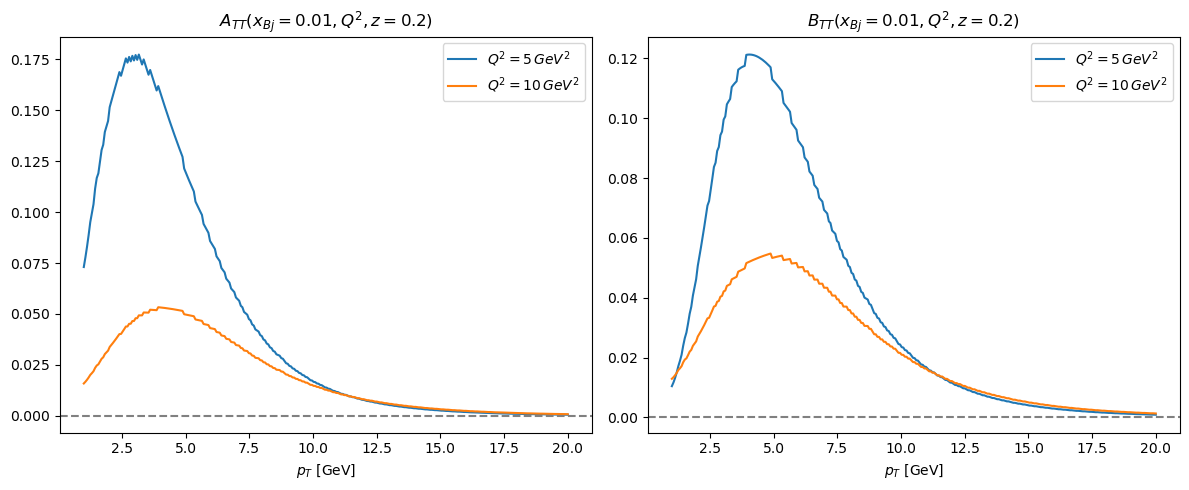

In [341]:
# plot Q variation 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# axes[0].plot(pT_values, A_TT_Q[0], label = r"$Q^2= 1 \,GeV^2$")
axes[0].plot(pT_values, A_TT_Q[1], label = r"$Q^2= 5 \,GeV^2$")
axes[0].plot(pT_values, A_TT_Q[2], label = r"$Q^2= 10 \,GeV^2$")
axes[0].legend()
# axes[0].semilogy()
axes[0].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[0].set_title(r'$A_{TT}(x_{Bj} = 0.01, Q^2, z=0.2)$')
axes[0].set_xlabel(r'$p_T$ [GeV]')

# axes[1].plot(pT_values, B_TT_Q[0], label = r"$Q^2= 1 \,GeV^2$",)
axes[1].plot(pT_values, B_TT_Q[1], label = r"$Q^2= 5 \,GeV^2$")
axes[1].plot(pT_values, B_TT_Q[2], label = r"$Q^2= 10\, GeV^2$")
axes[1].legend()
# axes[1].semilogy()
axes[1].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[1].set_title(r'$B_{TT}(x_{Bj} = 0.01, Q^2, z=0.2)$')
axes[1].set_xlabel(r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()

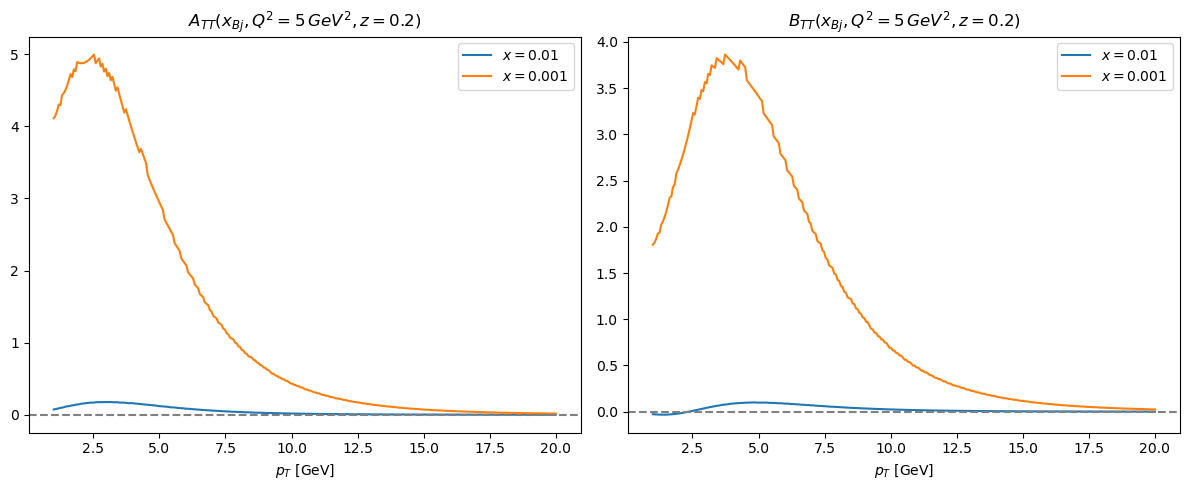

In [309]:
# plot xBj variation 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(pT_values, A_TT_xBj[0], label = r"$x=0.01$")
# axes[0].plot(pT_values, A_TT_xBj[1], label = r"$x=0.005$")
axes[0].plot(pT_values, A_TT_xBj[2], label = r"$x=0.001$")
axes[0].legend()
# axes[0].semilogy()
axes[0].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[0].set_title(r'$A_{TT}(x_{Bj}, Q^2 = 5\, GeV^2, z=0.2)$')
axes[0].set_xlabel(r'$p_T$ [GeV]')

axes[1].plot(pT_values, B_TT_xBj[0], label = r"$x=0.01$")
# axes[1].plot(pT_values, B_TT_xBj[1], label = r"$x=0.005$")
axes[1].plot(pT_values, B_TT_xBj[2], label = r"$x=0.001$")
axes[1].legend()
# axes[1].semilogy()
axes[1].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[1].set_title(r'$B_{TT}(x_{Bj}, Q^2 = 5\, GeV^2, z =0.2)$')
axes[1].set_xlabel(r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()

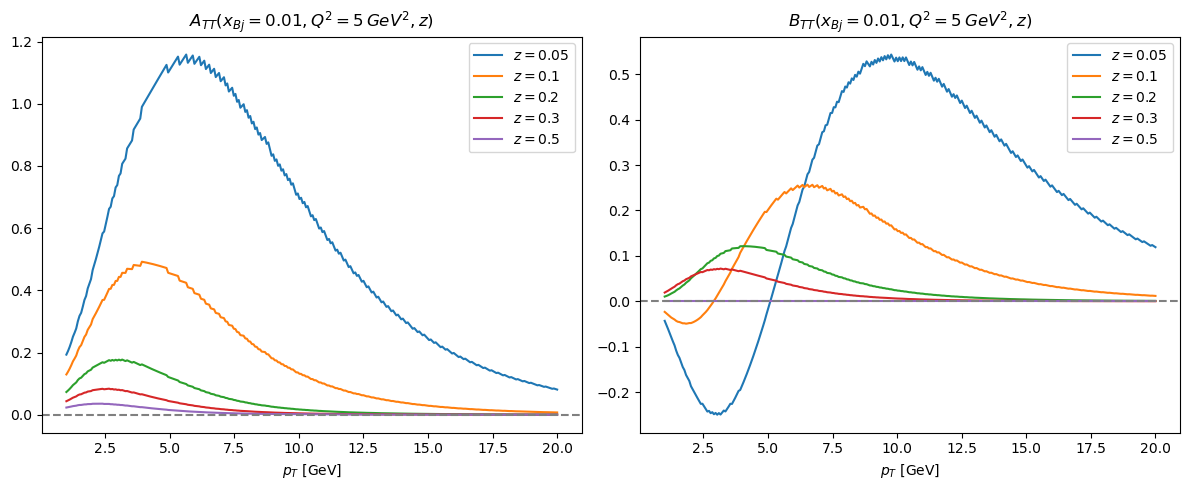

In [348]:
# plot z variation 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(pT_values, A_TT_z[0], label = r"$z=0.05$")
axes[0].plot(pT_values, A_TT_z[1], label = r"$z=0.1$")
axes[0].plot(pT_values, A_TT_z[2], label = r"$z=0.2$")
axes[0].plot(pT_values, A_TT_z[3], label = r"$z=0.3$")
axes[0].plot(pT_values, A_TT_z[4], label = r"$z=0.5$")
# axes[0].plot(pT_values, A_TT_z[3], label = r"$z=0.7$")
# axes[0].plot(pT_values, A_TT_z[4], label = r"$z=0.9$")
axes[0].legend()
# axes[0].semilogy()
axes[0].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[0].set_title(r'$A_{TT}(x_{Bj}=0.01, Q^2 = 5\, GeV^2, z)$')
axes[0].set_xlabel(r'$p_T$ [GeV]')

axes[1].plot(pT_values, B_TT_z[0], label = r"$z=0.05$")
axes[1].plot(pT_values, B_TT_z[1], label = r"$z=0.1$")
axes[1].plot(pT_values, B_TT_z[2], label = r"$z=0.2$")
axes[1].plot(pT_values, B_TT_z[3], label = r"$z=0.3$")
axes[1].plot(pT_values, B_TT_z[4], label = r"$z=0.5$")
axes[1].legend()
# axes[1].semilogy()
axes[1].axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
axes[1].set_title(r'$B_{TT}(x_{Bj}=0.01, Q^2 = 5\, GeV^2, z)$')
axes[1].set_xlabel(r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()